<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter06/Class_activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('cell_images'):
    !pip install -U -q torch_snippets
    !wget -q ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
    !unzip -qq cell_images.zip
    !rm cell_images.zip
from torch_snippets import *

     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 


In [ ]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [ ]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05), 
                  contrast=(0.95,1.05), 
                  saturation=(0.95,1.05), 
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [ ]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [ ]:
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

2020-11-08 18:09:42.461 | INFO     | torch_snippets.loader:Glob:181 - 27558 files found at cell_images/*/*.png
2020-11-08 18:09:43.093 | INFO     | __main__:__init__:6 - 20668
2020-11-08 18:09:43.094 | INFO     | __main__:__init__:6 - 6890


In [ ]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [ ]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.253	trn_acc: 0.900	val_loss: 0.176	val_acc: 0.945	(142.87s - 142.87s remaining)
EPOCH: 2.000	trn_loss: 0.175	trn_acc: 0.947	val_loss: 0.203	val_acc: 0.949	(285.57s - 0.00s remaining)


In [ ]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [ ]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [ ]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

2020-11-08 18:16:46.244 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


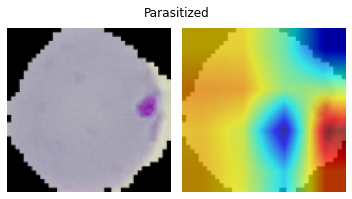

2020-11-08 18:16:46.394 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


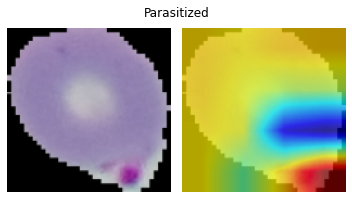

2020-11-08 18:16:46.547 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


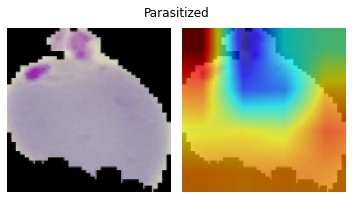

2020-11-08 18:16:46.721 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


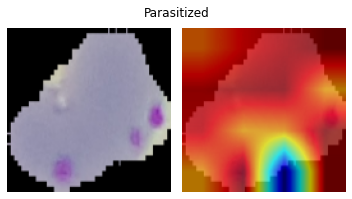

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


2020-11-08 18:16:46.895 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


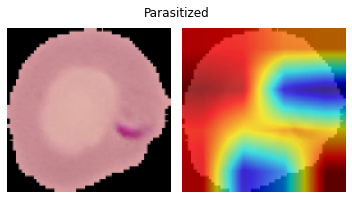

2020-11-08 18:16:47.052 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


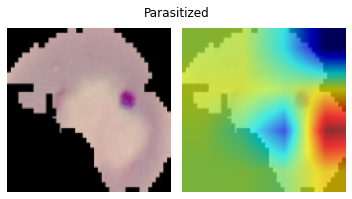

2020-11-08 18:16:47.208 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


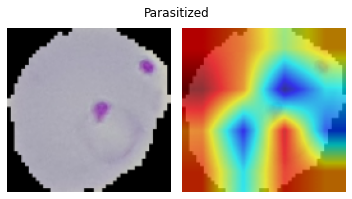

2020-11-08 18:16:47.354 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


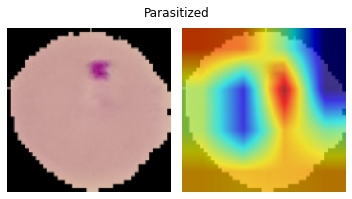

2020-11-08 18:16:47.500 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


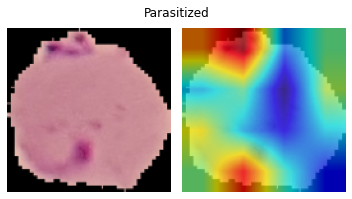

2020-11-08 18:16:47.743 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


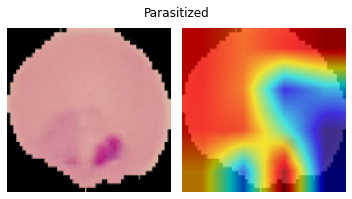

2020-11-08 18:16:47.902 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


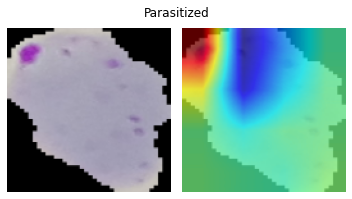

2020-11-08 18:16:48.051 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])


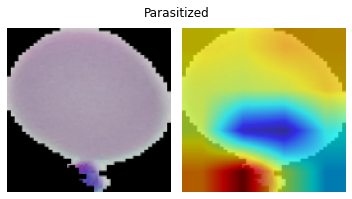

2020-11-08 18:16:48.223 | INFO     | torch_snippets.loader:subplots:375 - plotting 2 images in a grid of 1x2 @ (5, 3)


torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


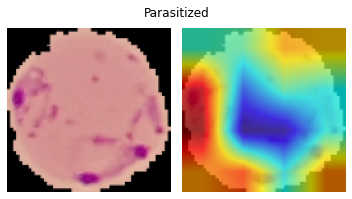

In [ ]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)